In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray
import pickle
import torch

#from zfa.core.default_dirs import DATA_ROOT

from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget

%matplotlib inline
%load_ext autoreload
%autoreload 2


#assert torch.cuda.is_available(), print('Not on a compute node. Do not run anything.')

In [2]:
DATA_ROOT = "/data/group_data/neuroagents_lab/neural_datasets/zfa_data"

In [3]:
from sklearn.preprocessing import MinMaxScaler

def normalize_series(series):
    # Ensure the series is in the correct shape for the MinMaxScaler (samples, features)
    reshaped_series = np.array(series).reshape(-1, 1)
    
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    normalized = scaler.fit_transform(reshaped_series)
    
    # Since our time series is a 1-D array, we can flatten the output to get it back into the original shape
    return normalized.flatten()

In [4]:
# has both neurons and glia

sesh1 = '/data/group_data/neuroagents_lab/neural_datasets/zfa_data/000350/sub-20161109-2/sub-20161109-2_ses-20161109T211950_ophys.nwb'
sesh2 = '/data/group_data/neuroagents_lab/neural_datasets/zfa_data/000350/sub-20170203-1/sub-20170203-1_ses-20170203T122038_ophys.nwb'
sesh3 = '/data/group_data/neuroagents_lab/neural_datasets/zfa_data/000350/sub-20170228-3/sub-20170228-3_ses-20170228T165730_ophys.nwb'
sesh4 = '/data/group_data/neuroagents_lab/neural_datasets/zfa_data/000350/sub-20170228-4/sub-20170228-4_ses-20170228T185002_ophys.nwb'



In [6]:
io = NWBHDF5IO(sesh3, mode="r", load_namespaces=True)
nwbfile = io.read()

trial_types = nwbfile.trials['trial_type']
behavior_state_types = nwbfile.processing['behavior']['ActivityStates']['state_type']
behavior_start_times = nwbfile.processing['behavior']['ActivityStates']['start_time']

glial_times = np.asarray(nwbfile.processing['ophys']['DfOverF']['GliaDfOverF'].timestamps)
glial_times

/home/rdkeller/miniconda3/envs/fishies/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/rdkeller/miniconda3/envs/fishies/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/rdkeller/miniconda3/envs/fishies/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


array([1.11860558e-02, 5.98203553e-01, 1.18538801e+00, ...,
       3.56046714e+03, 3.56105433e+03, 3.56164151e+03])

In [6]:
len(glial_times) - len(behavior_start_times)

5821

In [18]:
#TODO: Turn this into a script that takes as input the path and then can be executed in terminal by calling the script.
def get_neural_and_glial_trials(nwbfilepath):

    print('Reading file path...')
    io = NWBHDF5IO(nwbfilepath, mode="r", load_namespaces=True)
    nwbfile = io.read()
    
    print('Getting trial start and stop points...')
    glial_trace = nwbfile.processing['ophys']['DfOverF']['GliaDfOverF'].data
    neural_trace = nwbfile.processing['ophys']['DfOverF']['NeuronDfOverF'].data
    time_stamps = np.asarray(nwbfile.processing['ophys']['DfOverF']['GliaDfOverF'].timestamps)

    behavior_state_types = nwbfile.processing['behavior']['ActivityStates']['state_type']
    behavior_start_times = nwbfile.processing['behavior']['ActivityStates']['start_time']
    behavior_stop_times = nwbfile.processing['behavior']['ActivityStates']['stop_time']

    trial_types = nwbfile.trials['trial_type']
    trial_start_times = np.asarray(nwbfile.trials['start_time'])
    trial_stop_times = np.asarray(nwbfile.trials['stop_time'])

    window_size = 10


    print('Extracting glial and neural trials...')
    glial_trials = []
    neural_trials = []

    assert len(time_stamps) == glial_trace.shape[0], print('Wrong timestaps!')
    assert len(time_stamps) == neural_trace.shape[0], print('Wrong timestaps!')
    
    for i,behavior in enumerate(behavior_state_types):
        if behavior == 'passive':
            start_ind = np.argmin(np.abs(time_stamps - behavior_start_times[i]))
            #end_ind = np.argmin(np.abs(glial_times- behavior_stop_times[i]))

            glial_trial  = glial_trace[start_ind-window_size:start_ind + window_size,:]
            neural_trial = neural_trace[start_ind-window_size:start_ind + window_size,:]

            #if glial_trial.shape == neural_trial.shape:#, print('Glial time series and neural time series not the same length!')
            if len(glial_trial) == window_size*2:
                glial_trials.append(glial_trial)
                neural_trials.append(neural_trial)
    return np.stack(glial_trials), np.stack(neural_trials)


In [19]:
glial_trials_3,neural_trials_3 = get_neural_and_glial_trials(sesh3)
glial_trials_4,neural_trials_4 = get_neural_and_glial_trials(sesh4)


Reading file path...


/home/rdkeller/miniconda3/envs/fishies/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/rdkeller/miniconda3/envs/fishies/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/rdkeller/miniconda3/envs/fishies/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


Getting trial start and stop points...
Extracting glial and neural trials...
Reading file path...
Getting trial start and stop points...
Extracting glial and neural trials...


: 

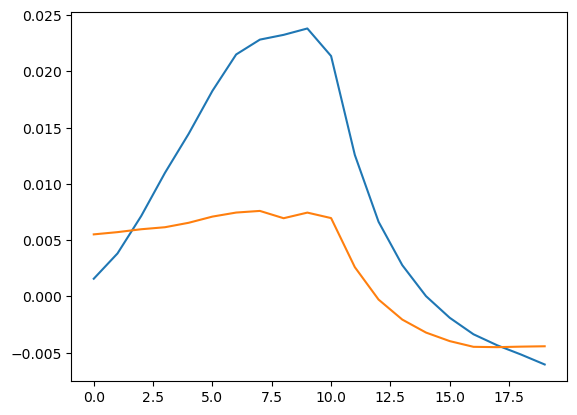

In [29]:
plt.plot(neural_trials_3.mean((0,2)))
plt.plot(neural_trials_4.mean((0,2)))
#glial_trials_3.shape

In [ ]:
# store data

def convert_np_to_xarray(nparray,window_size = 10):


    coords = {
        "trials": np.arange(nparray.shape[0]),  # replace with your actual coordinates
        "time": np.linspace(-window_size,window_size,nparray.shape[1]),    # replace with your actual coordinates
        "units": np.arange(nparray.shape[2])   # replace with your actual coordinates
    }

    # convert the numpy array to xarray
    xarray_from_nparray = xr.DataArray(nparray, dims=("trials", "time", "units"), coords = coords)

    return xarray_from_nparray


glial_trials_3_xarray = convert_np_to_xarray(glial_trials_3)
neural_trials_3_xarray = convert_np_to_xarray(neural_trials_3)

glial_trials_4_xarray = convert_np_to_xarray(glial_trials_4)
neural_trials_4_xarray = convert_np_to_xarray(neural_trials_4)
neural_tensors = {sesh3.split('/')[-1].replace('.nwb',''): neural_trials_3_xarray,
           sesh4.split('/')[-1].replace('.nwb',''): neural_trials_4_xarray}
glial_tensors = {sesh3.split('/')[-1].replace('.nwb',''): glial_trials_3_xarray,
           sesh4.split('/')[-1].replace('.nwb',''): glial_trials_4_xarray}

neural_trial_dict = {'filenames': [sesh3,sesh4], 'tensors': neural_tensors}
glial_trial_dict = {'filenames': [sesh3,sesh4], 'tensors': glial_tensors}


glial_save_dir = '/om2/group/yanglab/zfa/'
neural_save_dir = '/om2/group/yanglab/zfa/'

#save the data
with open(glial_save_dir + 'glial_trials.pickle', 'wb') as handle:
    pickle.dump(glial_trial_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(neural_save_dir + 'neural_trials.pickle', 'wb') as handle:
    pickle.dump(neural_trial_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


#check that I can load the stored data back 
with open(glial_save_dir + 'glial_trials.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [7]:
glial_save_dir = '/om2/group/yanglab/zfa/'
neural_save_dir = '/om2/group/yanglab/zfa/'

#check that I can load the stored data back 
with open(glial_save_dir + 'glial_trials.pickle', 'rb') as handle:
    glial_trials = pickle.load(handle)

with open(neural_save_dir + 'neural_trials.pickle', 'rb') as handle:
    neural_trials = pickle.load(handle)

# Inter Animal Consistency

In [4]:
from sklearn.model_selection import KFold
from brainmodel_utils.core.constants import RIDGECV_ALPHA_CV
from brainmodel_utils.neural_mappers.utils import generate_train_test_splits

from brainmodel_utils.metrics.consistency import get_linregress_consistency

In [5]:
splits = generate_train_test_splits(
        num_stim=20, num_splits=5, train_frac=0.5
    )

In [71]:
from sklearn.model_selection import KFold
from brainmodel_utils.core.constants import RIDGECV_ALPHA_CV
from brainmodel_utils.neural_mappers.utils import (
    generate_train_test_splits,
    convert_dict_to_tuple,
)
from brainmodel_utils.metrics.consistency import get_linregress_consistency



ModuleNotFoundError: No module named 'rel_inference'

In [ ]:
def build_param_lookup(args):
    if args.brain_areas is None:
        brain_areas = BRAIN_AREAS
    else:
        brain_areas = args.brain_areas.split(",")

    param_lookup = {}
    key = 0
    for brain_area in brain_areas:
        param_lookup[str(key)] = {
            "brain_area": brain_area,
            "train_frac": args.train_frac,
            "time_mode": args.time_mode,
            "temporal": args.temporal,
            "trial_threshold": args.trial_threshold,
            "downsample_rate": args.downsample_rate,
            "start_offset_sec": args.start_offset_sec,
            "trial_frac_lower_bound": args.trial_frac_lower_bound,
            "additional_target_offset_sec": args.additional_target_offset_sec,
            "num_splits": args.num_splits,
            "num_cv_splits": args.num_cv_splits,
            "num_bootstrap_iters": args.num_bootstrap_iters,
            "num_parallel_jobs": args.num_parallel_jobs,
            "enforce_finite_mean": True if not args.no_finite_mean_filt else False,
        }
        key += 1

    return param_lookup

def perform_cv(
    brain_area,
    train_frac,
    num_splits,
    num_cv_splits,
    num_parallel_jobs,
    temporal=False,
    trial_threshold=360,
    downsample_rate=None,
    start_offset_sec=0.0,
    trial_frac_lower_bound=0.5,
    additional_target_offset_sec=0.2,
    num_bootstrap_iters=1000,
    metric="pearsonr",
    enforce_finite_mean=True,
    time_mode="target_gocue",
):
    assert len(ANIMALS) == 2  # makes code below simpler

    packaged_fn = get_packaged_data_filename(
        brain_area=brain_area,
        time_mode=time_mode,
        temporal=temporal,
        collapse_temporal=True,
        trial_threshold=trial_threshold,
        start_offset_sec=start_offset_sec,
        downsample_rate=downsample_rate,
        enforce_finite_mean=enforce_finite_mean,
        trial_frac_lower_bound=trial_frac_lower_bound,
        additional_target_offset_sec=additional_target_offset_sec,
    )
    packaged_fn = os.path.join(NEURAL_RESP_PACKAGED, packaged_fn)
    if os.path.exists(packaged_fn):
        print(f"Loading packaged data from {packaged_fn}")
        brain_data = np.load(packaged_fn, allow_pickle=True)["arr_0"][()]
    else:
        if temporal:
            brain_data = get_single_area_common_stim_resp(
                brain_area=brain_area,
                time_mode=time_mode,
                temporal=temporal,
                collapse_temporal=True,
                trial_threshold=trial_threshold,
                start_offset_sec=start_offset_sec,
                downsample_rate=downsample_rate,
                enforce_finite_mean=enforce_finite_mean,
            )
        else:
            brain_data = get_single_area_common_stim_resp(
                brain_area=brain_area,
                time_mode=time_mode,
                temporal=temporal,
                enforce_finite_mean=enforce_finite_mean,
                trial_frac_lower_bound=trial_frac_lower_bound,
                additional_target_offset_sec=additional_target_offset_sec,
            )
    if temporal:
        num_stim = len(brain_data[ANIMALS[0]].stim_time)
    else:
        num_stim = len(brain_data[ANIMALS[0]].stimuli)

    splits = generate_train_test_splits(
        num_stim=num_stim, num_splits=num_splits, train_frac=train_frac
    )

    results_list = []
    for s in splits:
        results = {}
        for animal_pair in itertools.permutations(ANIMALS, r=2):
            source_animal = animal_pair[0]
            target_animal = animal_pair[1]
            target_resp = brain_data[target_animal]
            source_resp = brain_data[source_animal]
            # cv is only on the train data
            if temporal:
                target_resp_train = target_resp.isel(stim_time=s["train"])
                source_resp_train = source_resp.isel(stim_time=s["train"])
            else:
                target_resp_train = target_resp.isel(stimuli=s["train"])
                source_resp_train = source_resp.isel(stimuli=s["train"])
            assert target_resp_train.ndim == 3
            assert source_resp_train.ndim == 3

            kf = KFold(n_splits=num_cv_splits)
            cv_splits = []
            for cv_train_idx, cv_val_idx in kf.split(
                X=source_resp_train.mean(dim="trials", skipna=True)
            ):
                cv_splits.append({"train": cv_train_idx, "test": cv_val_idx})

            if target_animal not in results.keys():
                results[target_animal] = {}

            for alpha in RIDGECV_ALPHA_CV:
                map_kwargs = {
                    "map_type": "sklinear",
                    "map_kwargs": {
                        "regression_type": "Ridge",
                        "regression_kwargs": {"alpha": alpha},
                    },
                }
                # turn it into immutable tuple to store as a key
                map_kwargs_key = convert_dict_to_tuple(map_kwargs)
                results[target_animal][map_kwargs_key] = get_linregress_consistency(
                    source=source_resp_train,
                    target=target_resp_train,
                    map_kwargs=map_kwargs,
                    num_bootstrap_iters=num_bootstrap_iters,
                    num_parallel_jobs=num_parallel_jobs,
                    splits=cv_splits,
                    metric=metric,
                )

        results_list.append(results)

    fn = get_filename(
        map_name="ridgecv",
        brain_area=brain_area,
        interanimal=True,
        common_resp=True,
        num_splits=num_splits,
        num_cv_splits=num_cv_splits,
        train_frac=train_frac,
        trial_frac_lower_bound=trial_frac_lower_bound,
        additional_target_offset_sec=additional_target_offset_sec,
        num_bootstrap_iters=num_bootstrap_iters,
        metric=metric,
        enforce_finite_mean=enforce_finite_mean,
        time_mode=time_mode,
        temporal=temporal,
        collapse_temporal=True,
        trial_threshold=trial_threshold,
        start_offset_sec=start_offset_sec,
        downsample_rate=downsample_rate,
    )
    fn = os.path.join(NEURAL_FIT_CV_SEARCH_DIR, fn)
    np.savez(fn, results_list)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--brain-areas", type=str, default=None, required=True)
    parser.add_argument("--train-frac", type=float, default=0.8)
    parser.add_argument("--time-mode", type=str, default="target_gocue")
    parser.add_argument("--temporal", type=bool, default=False)
    parser.add_argument("--trial-threshold", type=int, default=360)
    parser.add_argument("--downsample-rate", type=int, default=None)
    parser.add_argument("--start-offset-sec", type=float, default=0.0)
    parser.add_argument("--trial-frac-lower-bound", type=float, default=0.5)
    parser.add_argument("--additional-target-offset-sec", type=float, default=0.2)
    parser.add_argument("--num-splits", type=int, default=5)
    parser.add_argument("--num-bootstrap-iters", type=int, default=1000)
    parser.add_argument("--num-cv-splits", type=int, default=5)
    parser.add_argument("--num-parallel-jobs", type=int, default=1)
    parser.add_argument("--no-finite-mean-filt", type=bool, default=False)
    args = parser.parse_args()

    params = build_param_lookup(args)
    print(f"Num jobs: {len(list(params.keys()))}")
    curr_params = params[os.environ.get("SLURM_ARRAY_TASK_ID")]
    perform_cv(**curr_params)